In [54]:
from pyDOE3 import ff2n
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools


Para abrirlo en colab: <a target="_blank" href="https://githubtocolab.com/SysBioengLab/IIQ3402-Statistical-Design/blob/main/Ayudantias/Ayudantia9_DisenoFactorial2k.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



# Ayudantía 9: Diseños factoriales $2^k$

Los diseño factoriales del tipo $2^k$ permiten evaluar el efecto de diferentes factores sobre una variable en específico. La gracia de estos diseños es que se utilizan dos niveles por factor: -1 (el menor), +1 (el mayor). De esta forma se puede evaluar el efecto de los factores cuando el nivel es menor o mayor, ayudando en las conclusiones de los mismos experimentos.



# Diseño Factorial $2^k$ con repeticiones


Considere el experimento descrito en el Ejemplo 6.1 del texto guía. Los datos observados se presentan en la Tabla del enunciado. El objetivo del experimento es estudiar cómo afectan tres factores (A, B y C) a la tasa de grabado (etch rate) en un proceso de manufactura.

In [5]:
df_2k_replicas = pd.DataFrame({
    'A': [0.8, 1.2, 0.8, 1.2, 0.8, 1.2, 0.8, 1.2],
    'B': [125, 125, 200, 200, 125, 125, 200, 200],
    'C': [275, 275, 275, 275, 325, 325, 325, 325],
    'Rep1': [550, 669, 633, 642, 1037, 749, 1075, 729],
    'Rep2': [604, 650, 601, 635, 1052, 868, 1063, 860]
})

## Codificación

> Codifique las variables independientes en los niveles $\{-1, +1\}$. Explique por qué es conveniente utilizar variables codificadas en diseños factoriales $2^k$.

Para realizar la codificación de una variable, es necesario identificar el mínimo y máximo valor que esta puede tomar. De esta manera, se utiliza la siguiente formula para codificar la variable $x$ -por ejemplo- desde su rango original a valores $\{-1, +1\}$:

$$
x_{\text{coded}} = \frac{ x - \frac{x_{\text{max}} + x_{\min}}{2} }{\frac{x_{\text{max}} - x_{\min}}{2}}
$$



Esta función en python puede ser aplicada de la siguiente forma:

In [ ]:
from sklearn.preprocessing import minmax_scale  

df_2k_replicas_coded = df_2k_replicas.copy()
df_2k_replicas_coded['A'] = minmax_scale(df_2k_replicas_coded['A'], feature_range=(-1, 1)).round(2)
df_2k_replicas_coded['B'] = minmax_scale(df_2k_replicas_coded['B'], feature_range=(-1, 1)).round(2)
df_2k_replicas_coded['C'] = minmax_scale(df_2k_replicas_coded['C'], feature_range=(-1, 1)).round(2)

In [11]:
df_2k_replicas_coded

,A,B,C,Rep1,Rep2
0,-1.0,-1.0,-1.0,550,604
1,1.0,-1.0,-1.0,669,650
2,-1.0,1.0,-1.0,633,601
3,1.0,1.0,-1.0,642,635
4,-1.0,-1.0,1.0,1037,1052
5,1.0,-1.0,1.0,749,868
6,-1.0,1.0,1.0,1075,1063
7,1.0,1.0,1.0,729,860


La codificación de las variables permite darle la misma importancia a cada variable, ayudando a sacar conclusiones respecto a la importancia relativa de cada factor en el experimento en concreto.

## Cálculo de efecto medio de tratamientos

> Calcule la respuesta total para cada tratamiento. A partir de estas, determine los contrastes y estime los efectos principales e interaccione.

La respuesta total para un tratamiento se puede calcular al sumar la respuesta para cada condición. En este caso las condiciones se definen como:

1. (1): Tanto A como B -1
2. a: A = +1 y B = -1
3. b: A = -1 y B = +1
4. ab: A = +1 y B = +1

Así, la respuesta total de (1) corresponde a la suma de respuestas que se cumple la condición de (1), y así sucesivamente.

Ahora, para hacerlo en python, vamos a editar el dataframe para ayudar en la resolución.

In [385]:
def get_codification(df, factor_names):
    
    if factor_names is None:
        raise ValueError("factor_names must be provided")
    
    for factor in factor_names:
        if factor not in df.columns:
            raise ValueError(f"Factor '{factor}' not found in DataFrame columns")
    codes = []
    for index in range(len(df)):
        row = df.iloc[index]
        if df.loc[index, factor_names].astype(int).to_list() == [-1] * len(factor_names):
            codes.append('(1)')
        else:
            code = '('
            for factor in factor_names:
                if row[factor] == 1:
                    code += factor

            code += ')'
            codes.append(code)
    return codes     

def generar_matriz_contraste(factores):
    """
    Genera la matriz de contraste ortogonal para un diseño 2^k con índice simbólico estándar.

    Parámetros:
    -----------
    factores : list of str
        Lista de nombres de factores, ej. ['A', 'B', 'C']

    Retorna:
    --------
    X : pd.DataFrame
        Matriz de diseño codificada con índice simbólico tipo '(A)', '(AB)', etc.

    nombres_columnas : list of str
        Columnas del DataFrame en orden: (Intercept), principales e interacciones
    """
    k = len(factores)
    
    # Combinaciones de niveles -1 y +1
    niveles = list(itertools.product([-1, 1], repeat=k))
    df = pd.DataFrame(niveles, columns=factores)

    # Agregar el intercepto
    df['(Intercept)'] = 1

    # Construir interacciones
    interacciones = []
    for r in range(2, k + 1):
        for comb in itertools.combinations(factores, r):
            nombre = ''.join(comb)
            df[nombre] = df[list(comb)].prod(axis=1)
            interacciones.append(nombre)

    # Orden de columnas
    columnas = ['(Intercept)'] + factores + interacciones
    X = df[columnas]

    # Construir nombres de efectos como índices tipo '(1)', '(A)', '(AB)', etc.
    etiquetas = []
    for nivel in niveles:
        cod = ''.join([factores[i] for i, v in enumerate(nivel) if v == 1])
        etiquetas.append(f"({cod})" if cod else "(1)")
    
    X.index = pd.Index(etiquetas, name="Codification")

    return X, columnas
    
    
rep1 = df_2k_replicas_coded[['A', 'B', 'C', 'Rep1']].copy().rename(columns={'Rep1': 'Response'})
rep1['Replicate'] = 1
rep2 = df_2k_replicas_coded[['A', 'B', 'C', 'Rep2']].copy().rename(columns={'Rep2': 'Response'})
rep2['Replicate'] = 2
df_2k_coded = pd.concat([rep1, rep2], ignore_index=True)
df_2k_coded['Codification'] = get_codification(df_2k_coded, ['A', 'B', 'C'])
### calculamos efecto total
df_total_effect = df_2k_coded.groupby('Codification')['Response'].sum()

matrix_contraste = generar_matriz_contraste(['A', 'B', 'C'])[0]


df_total_effect = df_total_effect.loc[matrix_contraste.index].values


n = len(df_2k_coded['Replicate'].unique()) # Número de réplicas
normalization = (2 ** (len(['A', 'B', 'C']) - 1) * n )  # Normalización para el total de efectos
efectos_medios = matrix_contraste.T @ df_total_effect  / normalization
efectos_medios

(Intercept)    1552.125
A              -101.625
B                 7.375
C               306.125
AB              -24.875
AC             -153.625
BC               -2.125
ABC               5.625
dtype: float64

Estos efectos van a definir el efecto medio que se genera cuando los efectos pasan desde -1 -> +1.

## Regresión lineal como estimador de efecto

> Ajuste un modelo de regresión lineal que incluya efectos principales e interacciones. Luego:
>> 1. Verifique los supuestos del modelo ajustado mediante gráficos de residuos y pruebas de normalidad/homocedasticidad.
>> 2. Realice un análisis ANOVA para evaluar la significancia estadística de los efectos.
>> 3. Si corresponde, construya superficies de respuesta y gráficos de contorno para visualizar cómo se relacionan las variables significativas con la respuesta.

Recordando un modelo de regresión lineal:

$$
\mathbf{y} = \beta_0 + \beta_A \mathbf{x}_A + \beta_B \mathbf{x}_B + \beta_C \mathbf{x}_C + \beta_{AB} \mathbf{x}_{AB} + \beta_{BC} \mathbf{x}_{BC} + \beta_{AC} \mathbf{x}_{AC} + \beta_{ABC}\mathbf{x}_A \mathbf{x}_B \mathbf{x}_C
$$ 

En este caso, ajustamos nuestro modelo de regresión lineal sobre las variables codificadas, lo cuál permite atribuir el mismo peso a cada variable.

In [143]:
from statsmodels.formula.api import ols

modelo1 = ols('Response ~ A * B * C', data=df_2k_coded).fit()
print(modelo1.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     32.56
Date:                Tue, 27 May 2025   Prob (F-statistic):           2.90e-05
Time:                        14:34:13   Log-Likelihood:                -78.916
No. Observations:                  16   AIC:                             173.8
Df Residuals:                       8   BIC:                             180.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    776.0625     11.865     65.406      0.0

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=16



Pero, ¿por qué estamos realizando una regresión lineal sobre las variables codificadas y no las reales?

In [386]:

df_2k_replicas = pd.DataFrame({
    'A': [0.8, 1.2, 0.8, 1.2, 0.8, 1.2, 0.8, 1.2],
    'B': [125, 125, 200, 200, 125, 125, 200, 200],
    'C': [275, 275, 275, 275, 325, 325, 325, 325],
    'Rep1': [550, 669, 633, 642, 1037, 749, 1075, 729],
    'Rep2': [604, 650, 601, 635, 1052, 868, 1063, 860]
})

rep1 = df_2k_replicas[['A', 'B', 'C', 'Rep1']].copy().rename(columns={'Rep1': 'Response'})
rep1['Replicate'] = 1
rep2 = df_2k_replicas[['A', 'B', 'C', 'Rep2']].copy().rename(columns={'Rep2': 'Response'})
rep2['Replicate'] = 2
df = pd.concat([rep1, rep2], ignore_index=True)

modelo_nocoded = ols('Response ~ A * B * C', data=df).fit() 
print(modelo_nocoded.summary()) 

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     32.56
Date:                Wed, 28 May 2025   Prob (F-statistic):           2.90e-05
Time:                        11:02:20   Log-Likelihood:                -78.916
No. Observations:                  16   AIC:                             173.8
Df Residuals:                       8   BIC:                             180.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6487.3333   3239.947     -2.002      0.0

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=16



Si recordamos, para verificar la efecividad y supuestos de una regresión lineal, podemos evaluarlo por medio de la distribución de los residuos.

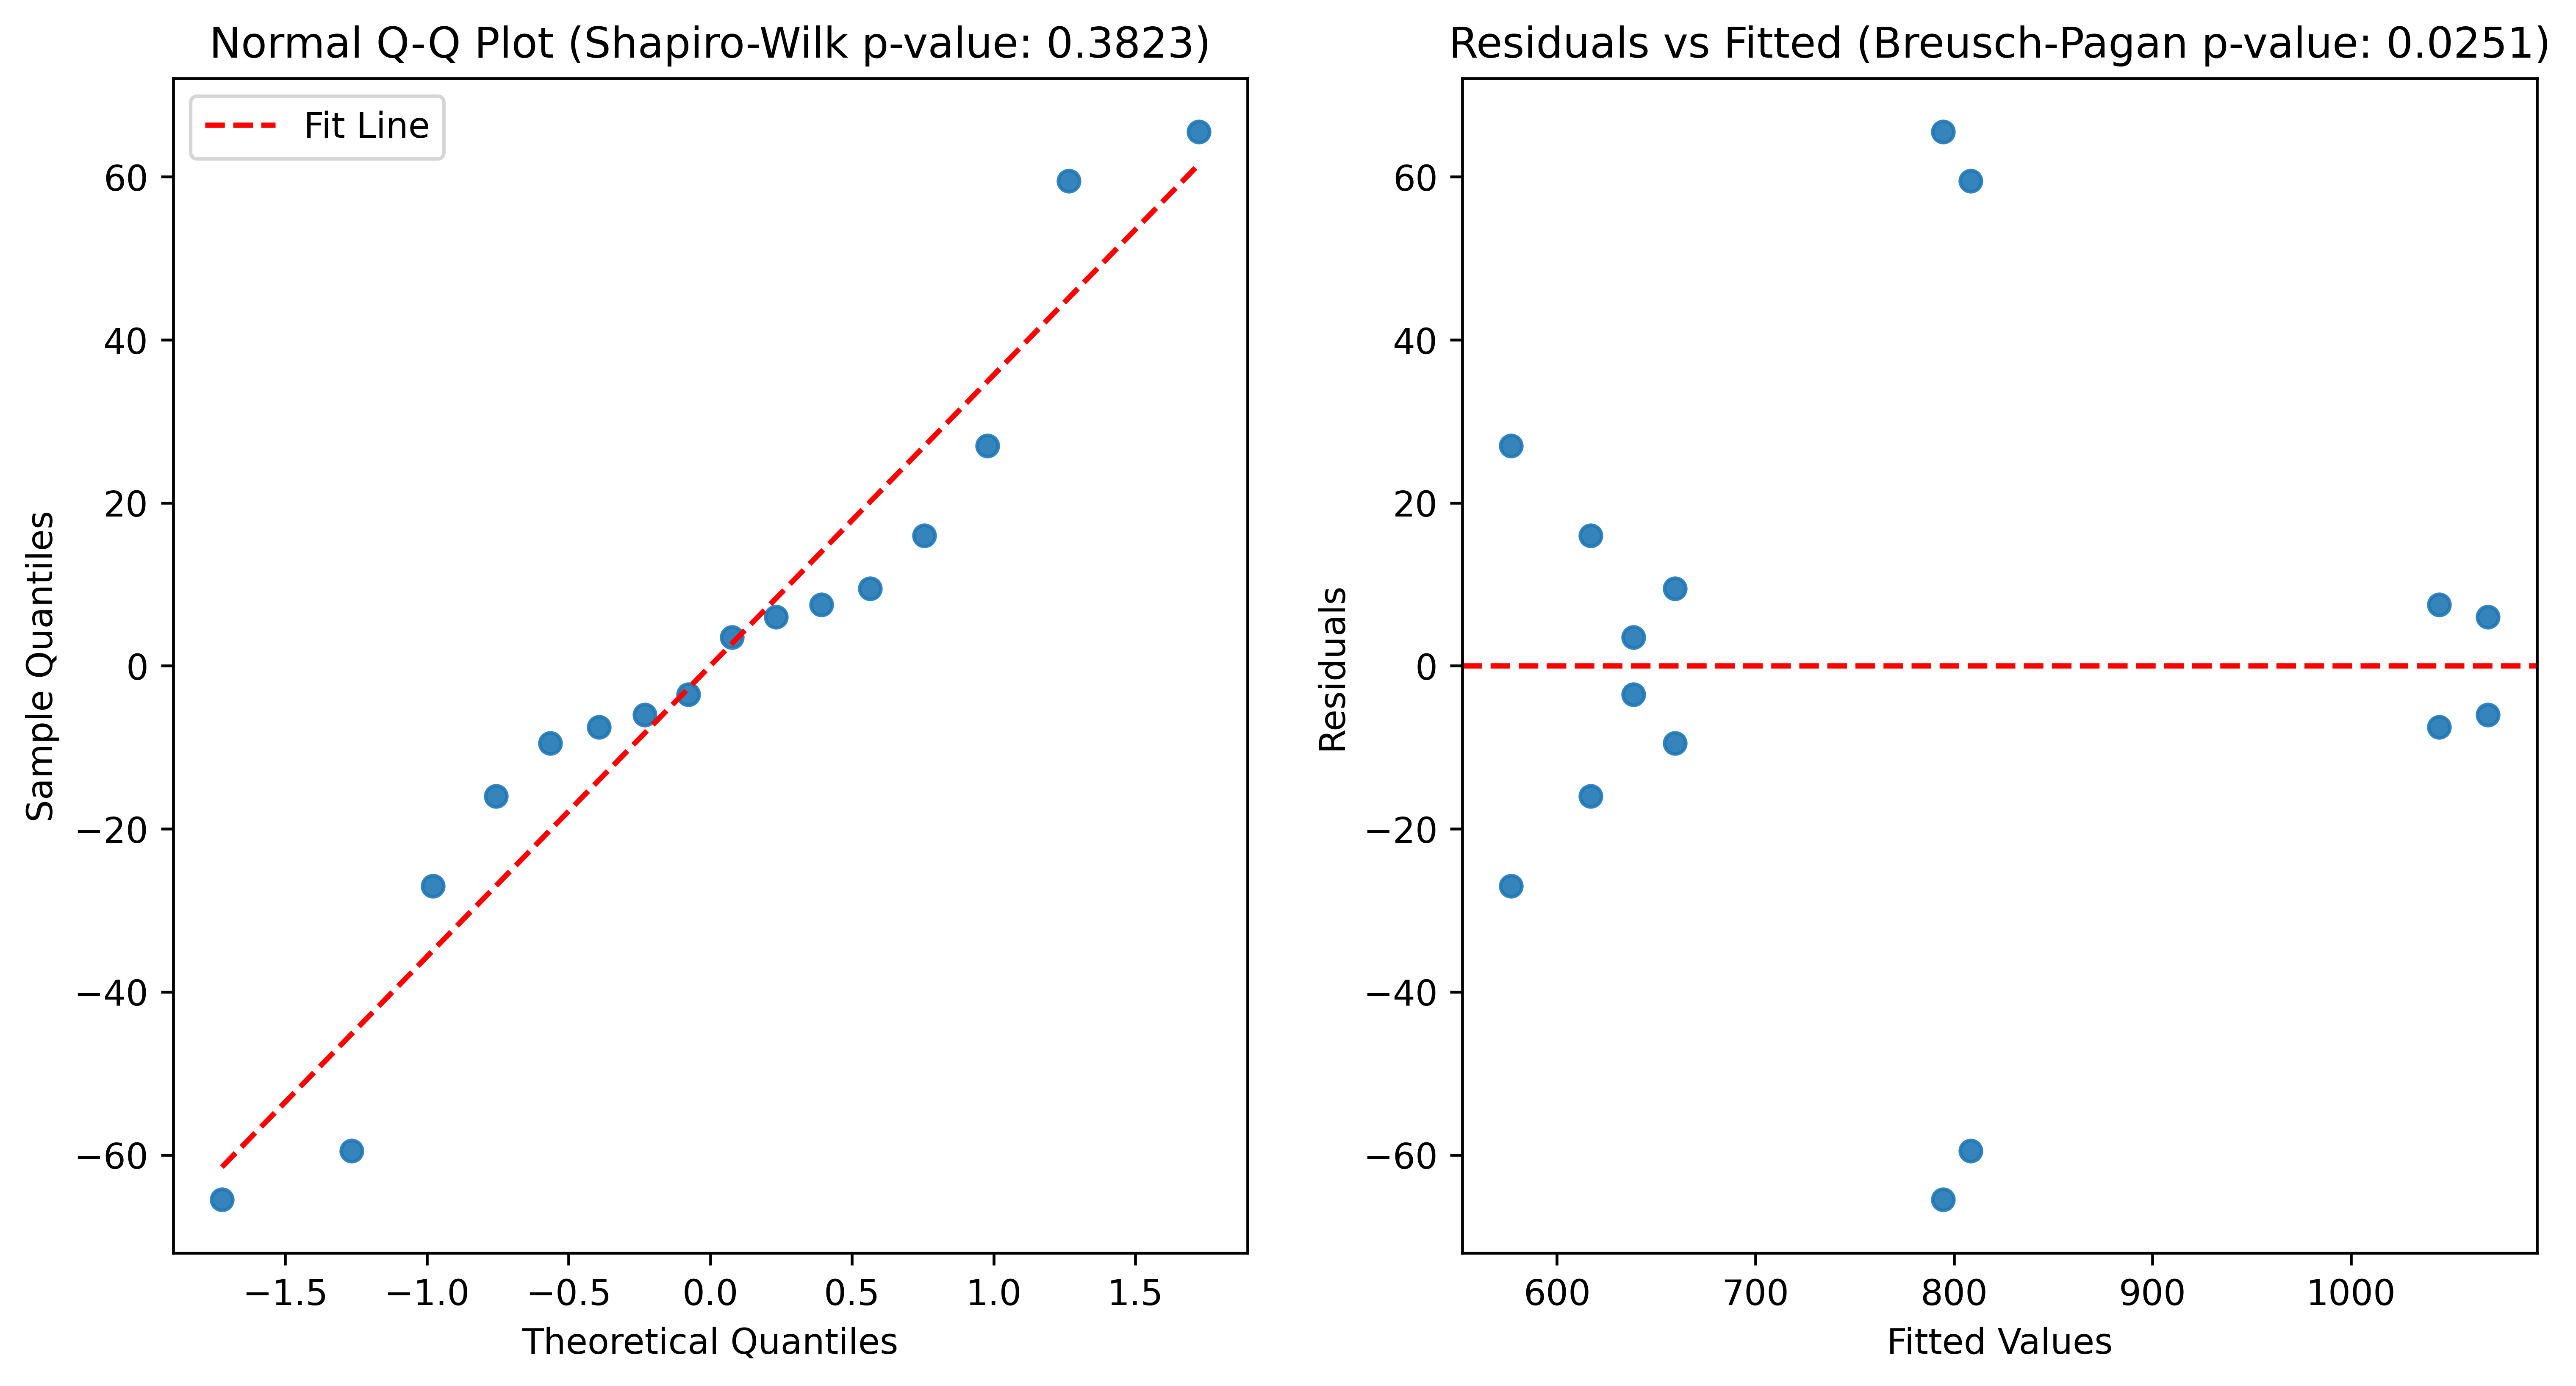

In [390]:
import scipy.stats as st
from statsmodels.stats.diagnostic import het_breuschpagan
resid = modelo1.resid

fig, ax = plt.subplots(1,2,figsize=(12, 6), dpi = 600)  
(osm, osr), (slope, intercept, r) = st.probplot(resid, dist="norm")
# ax[0].set_title('Normal Q-Q Plot')
ax[0].set_xlabel('Theoretical Quantiles')
ax[0].set_ylabel('Sample Quantiles')
ax[0].scatter(osm, osr, alpha=0.9)
shapiro = st.shapiro(resid)
ax[0].set_title(f'Normal Q-Q Plot (Shapiro-Wilk p-value: {shapiro.pvalue:.4f})')
ax[0].plot(osm, slope * osm + intercept, color='red', linestyle='--', label='Fit Line')
ax[0].legend()

ax[1].scatter(modelo1.fittedvalues, resid, alpha=0.9)
ax[1].axhline(0, color='red', linestyle='--')
ax[1].set_xlabel('Fitted Values')
ax[1].set_ylabel('Residuals')

bechun_pagan_p = het_breuschpagan(resid, modelo1.model.exog)[1]
ax[1].set_title(f'Residuals vs Fitted (Breusch-Pagan p-value: {bechun_pagan_p:.4f})')   
plt.show()

Podemos ver que el modelo cumple con el supuesto de normalidad, pero existe heterocedasticidad en los datos, por lo cuál hay que tomar los resultados con precuación.

## ANOVA sobre diseños $2^k$

> Realice un análisis ANOVA para evaluar la significancia estadística de los efectos.

In [391]:
from statsmodels.stats.anova import anova_lm
anova_results = anova_lm(modelo1, typ=2)
print(anova_results)

               sum_sq   df           F    PR(>F)
A          41310.5625  1.0   18.339364  0.002679
B            217.5625  1.0    0.096584  0.763911
A:B         2475.0625  1.0    1.098776  0.325168
C         374850.0625  1.0  166.410505  0.000001
A:C        94402.5625  1.0   41.908965  0.000193
B:C           18.0625  1.0    0.008019  0.930849
A:B:C        126.5625  1.0    0.056186  0.818586
Residual   18020.5000  8.0         NaN       NaN


¿Qué podemos interpretar sobre estos resultados? 

> Si corresponde, construya superficies de respuesta y gráficos de contorno para visualizar cómo se relacionan las variables significativas con la respuesta.

A partir del ANOVA y análisis de regresión lineal, podemos descartar la influencia del factor B -y sus combinaciones- con la variable de respuesta. De esta forma, nos quedamos con el siguiente modelo.

In [392]:
red_model = ols('Response ~ A * C', data=df_2k_coded).fit()
print(red_model.summary())  

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     97.91
Date:                Wed, 28 May 2025   Prob (F-statistic):           1.05e-08
Time:                        11:11:14   Log-Likelihood:                -80.086
No. Observations:                  16   AIC:                             168.2
Df Residuals:                      12   BIC:                             171.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    776.0625     10.423     74.458      0.0

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=16



En este caso podemos ver el cambio en el $R^2-\text{adj}$ para analizar que tanto *empeoro* el model.

- Modelo completo: 0.931 ($R^2$ = 0.966)
- Modelo reducido: 0.951 ($R^2$ = 0.961)

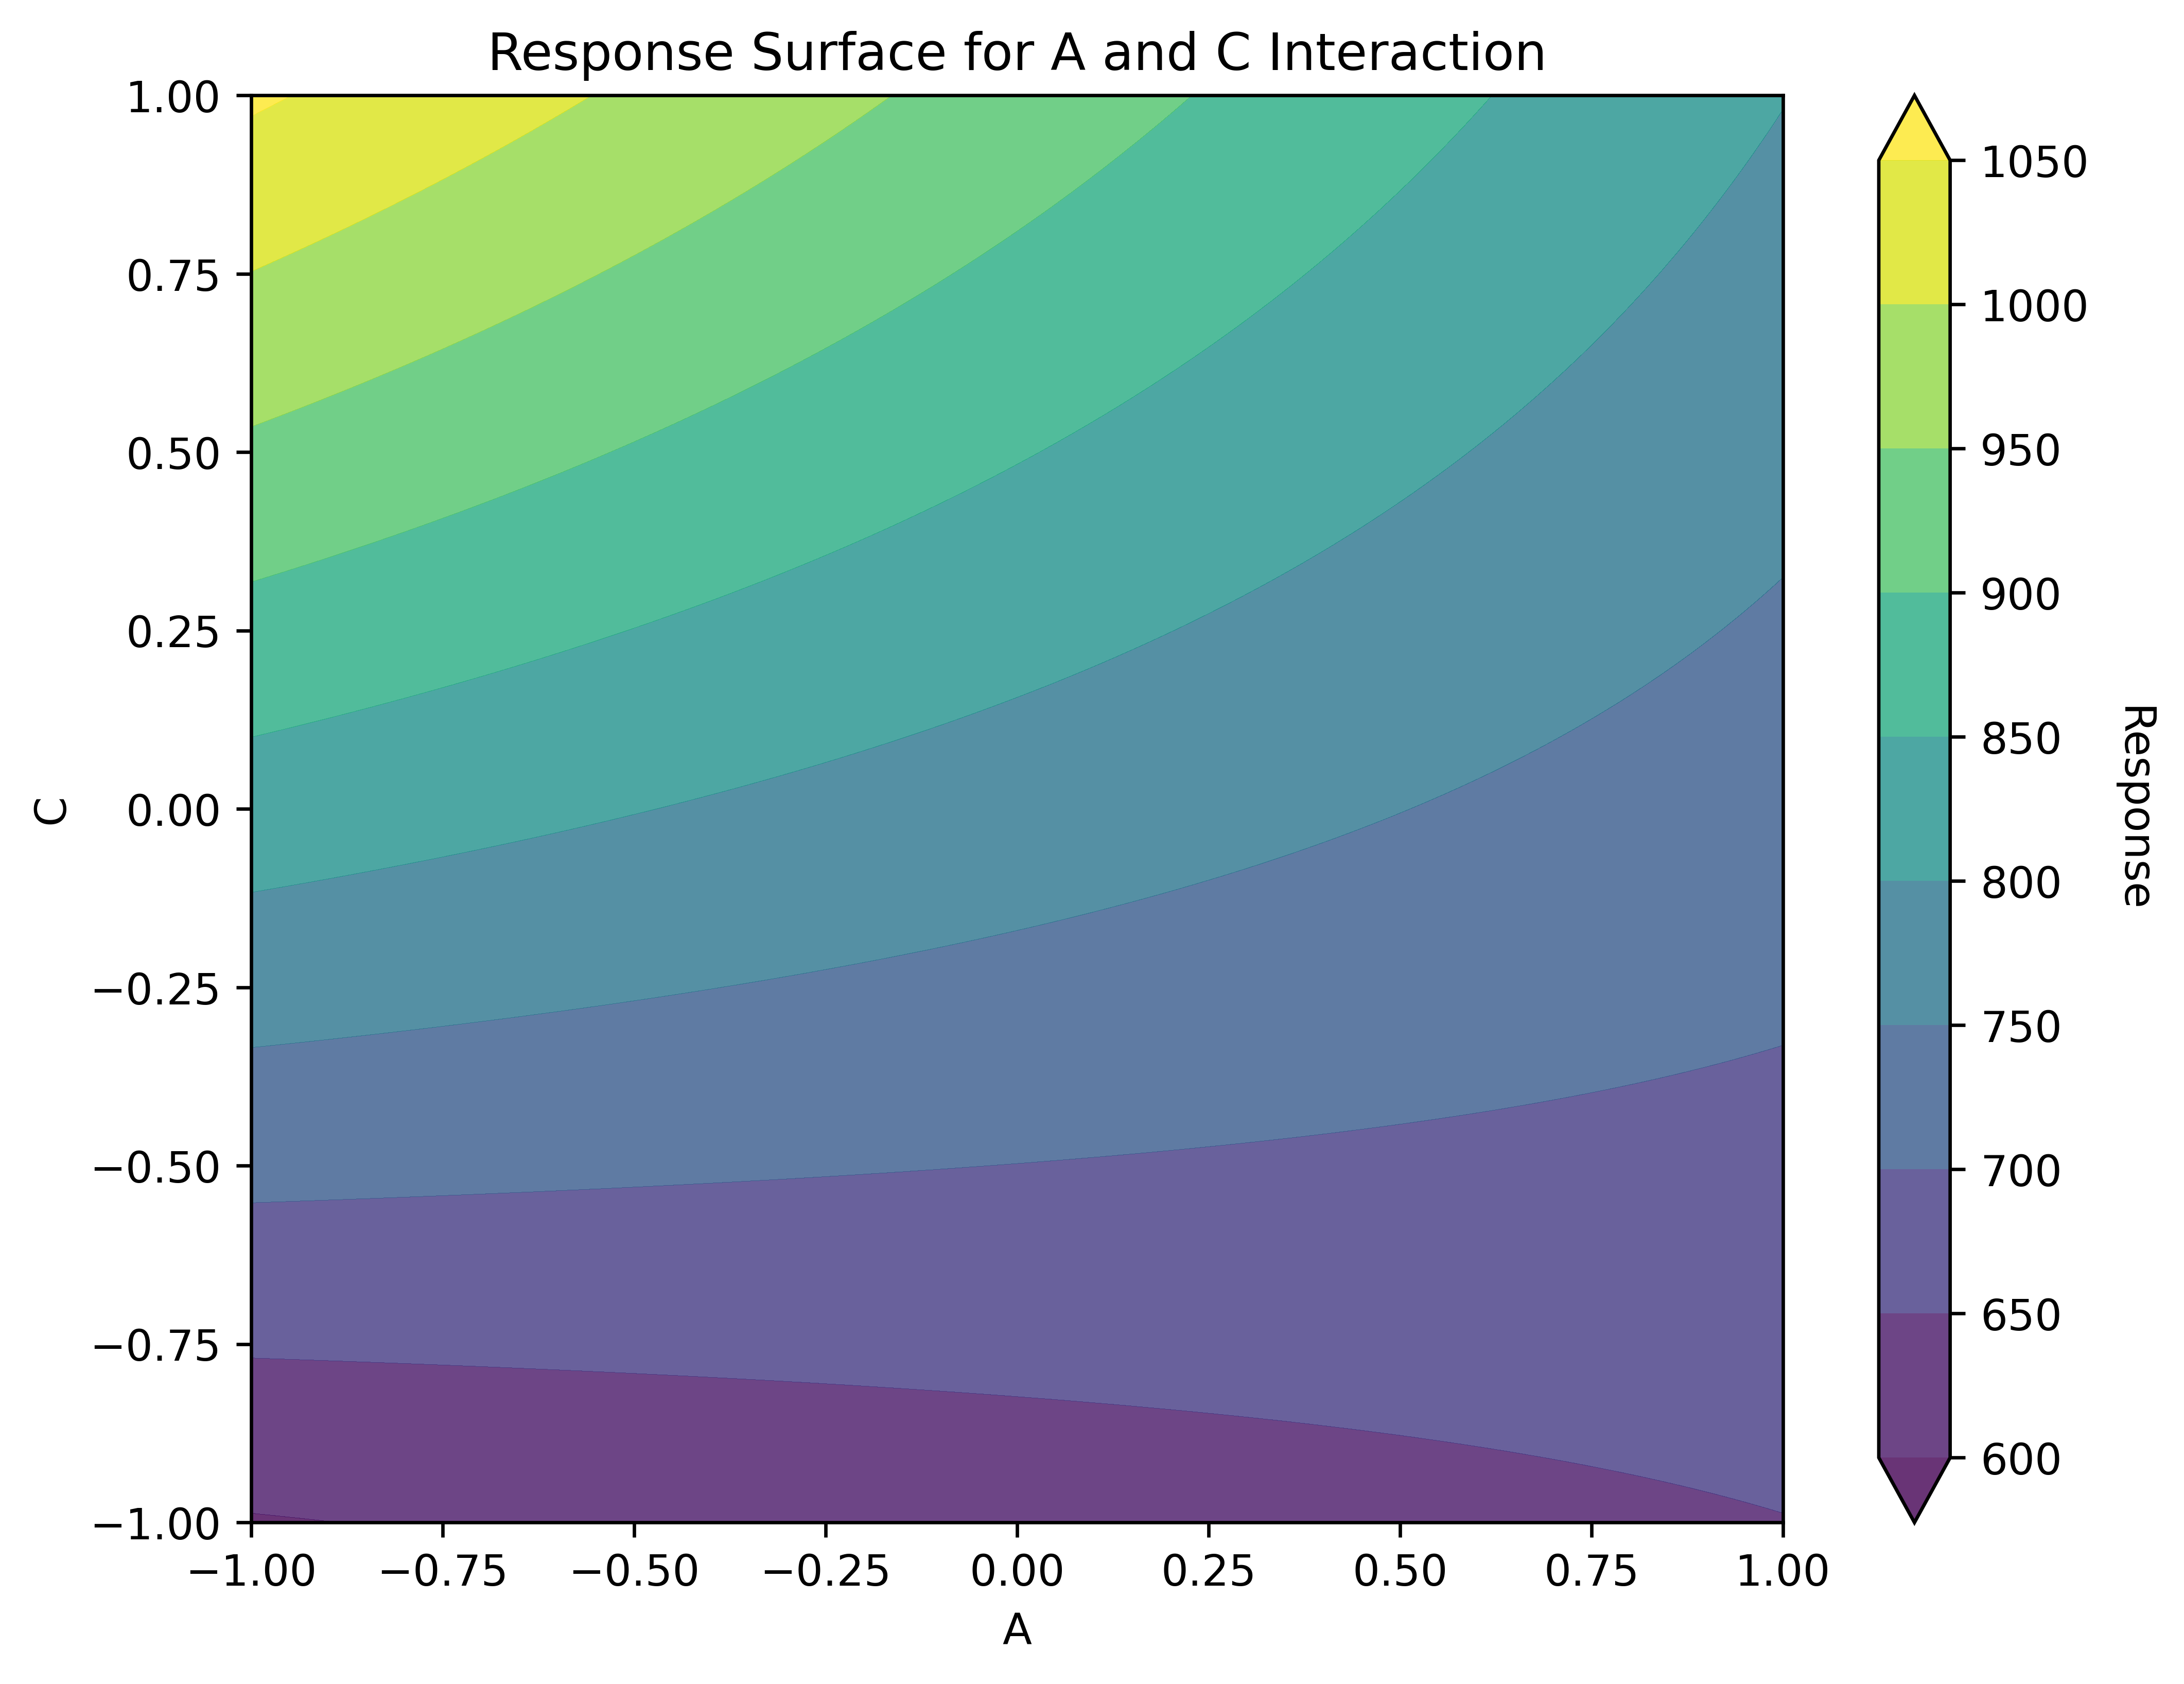

In [397]:
a, c = np.linspace(-1, 1, 100), np.linspace(-1, 1, 100) # generamos rangos de valores para A y C
A, C = np.meshgrid(a, c)  # creamos una malla de valores 
# calculamos los valores de la respuesta para cada combinación de A y C
y = red_model.params['Intercept'] + red_model.params['A'] * A + red_model.params['C'] * C + red_model.params['A:C'] * A * C

fig, ax = plt.subplots(figsize=(8, 6), dpi=600)
cs = ax.contourf(A, C, y, levels=10, cmap='viridis', alpha=0.8, extend='both')
cbar = fig.colorbar(cs, ax=ax)

cbar.set_label('Response', rotation=270, labelpad=15)
ax.set_xlabel('A')
ax.set_ylabel('C')
ax.set_title('Response Surface for A and C Interaction')
plt.show()


In [398]:

import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=y, x=A, y=C, colorscale='Viridis')])

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title=dict(text='Response Surface and Contour'), autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

## Comparación de Efecto y Regresión Lineal

> Compare los efectos estimados mediante el enfoque de contrastes con los estimados por regresión. ¿Son consistentes? Explique las posibles discrepancias.

En primera instancia miremos los efectos calculados y los parámtetros de la regresión lineal.

In [399]:
display(efectos_medios)
display(modelo1.params)

(Intercept)    1552.125
A              -101.625
B                 7.375
C               306.125
AB              -24.875
AC             -153.625
BC               -2.125
ABC               5.625
dtype: float64

Intercept    776.0625
A            -50.8125
B              3.6875
A:B          -12.4375
C            153.0625
A:C          -76.8125
B:C           -1.0625
A:B:C          2.8125
dtype: float64

Podemos ver que el valor del coeficiente de un modelo de regresión lineal corresponde a la mitad del efecto medio estimado. Esto se debe a que el efecto hace referencia a un cambio de 2 unidades -1 -> 1, mientras que los coeficientes de una regresión lineal son cambios unitarios. Por aquella razón, el coeficiente de la regresión lineal siempre será la mitad del efecto real de la variable.

In [401]:
efect_params = modelo1.params*2
display(efect_params)

Intercept    1552.125
A            -101.625
B               7.375
A:B           -24.875
C             306.125
A:C          -153.625
B:C            -2.125
A:B:C           5.625
dtype: float64

> Genere gráficos de interacción para los factores más relevantes. Interprete las posibles sinergias o antagonismos entre factores.

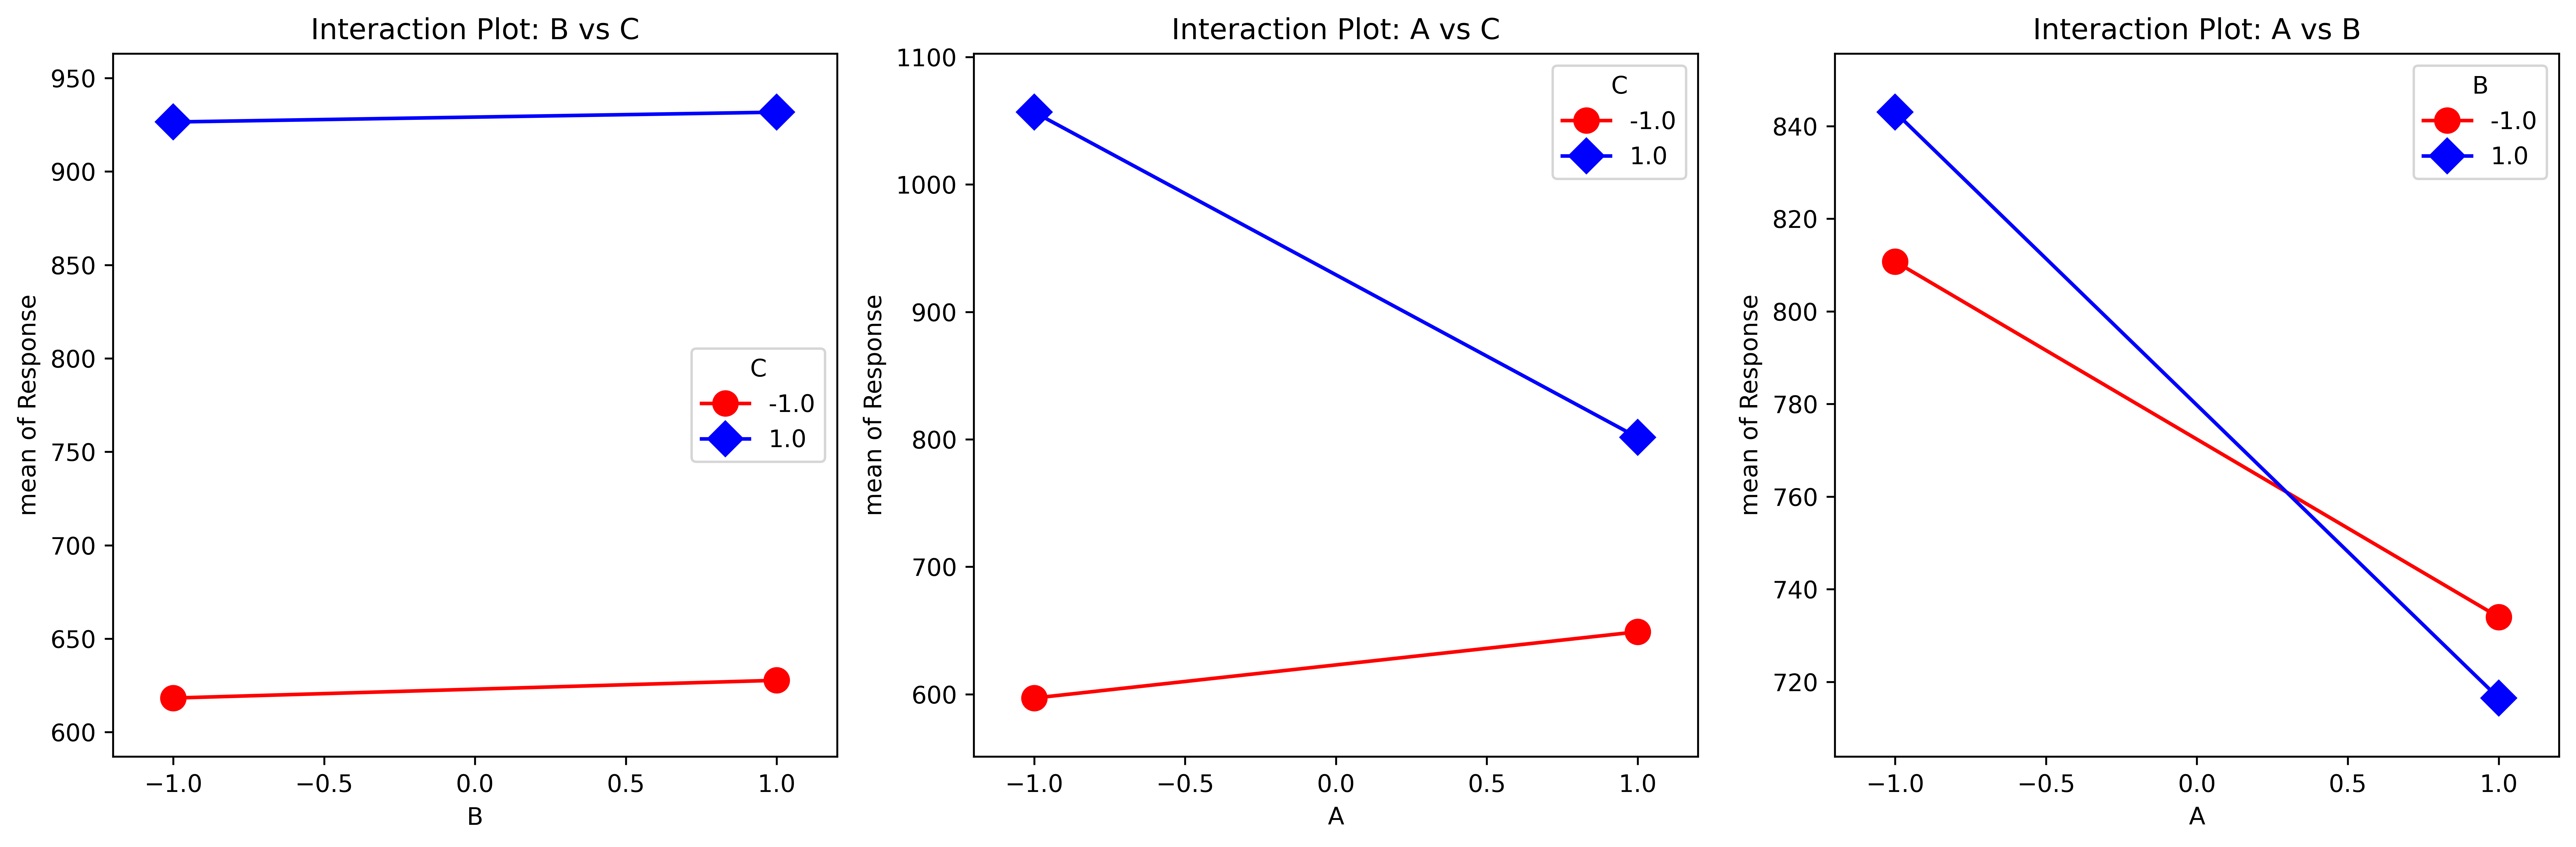

In [402]:
from statsmodels.graphics.api import interaction_plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=600)
interaction_plot(
    df_2k_coded['B'], df_2k_coded['C'], df_2k_coded['Response'], ax=ax[0],
    colors=['red', 'blue'], markers=['o', 'D'], ms=10, xlabel='B', ylabel='Response'
)
ax[0].set_title('Interaction Plot: B vs C')
interaction_plot(
    df_2k_coded['A'], df_2k_coded['C'], df_2k_coded['Response'], ax=ax[1],
    colors=['red', 'blue'], markers=['o', 'D'], ms=10, xlabel='A', ylabel='Response'
)
ax[1].set_title('Interaction Plot: A vs C')
interaction_plot(
    df_2k_coded['A'], df_2k_coded['B'], df_2k_coded['Response'], ax=ax[2],
    colors=['red', 'blue'], markers=['o', 'D'], ms=10, xlabel='A', ylabel='Response'
)
ax[2].set_title('Interaction Plot: A vs B')
plt.tight_layout()
plt.show()



## Intervalos de Confianza

> Estime intervalos de confianza al 95% para los efectos principales e interacciones. Interprete los resultados obtenidos.

Recordemos que la función que permite calcular el intervalo de confianza del 95% viene dado por la siguiente expresión:
$$
\text{efecto} ± SE(\text{efecto}) \cdot t_{\alpha/2, N-p}
$$

Donde N son la cantidad de experimentos y p la cantidad de parámetros.

Para la estimación del Standard Error del efecto se utiliza la siguiete expresión:

$$
SE(\text{efecto}) = \frac{2 S}{\sqrt{n 2 ^ k }}
$$

Donde podemos aproximar la desviación estándar de los datos mediante el $MS_E$:
$$
S^2 = MS_E
$$

In [239]:
n = df_2k_coded['Replicate'].nunique()  # Número de réplicas
k = len(['A', 'B', 'C'])  # Número de factores
se_efecto = 2 * np.sqrt(modelo1.mse_resid) / np.sqrt( 2 * 2 ** k)  
conf_ = st.t.ppf(1 - 0.05/2, 8)
se_efecto = se_efecto * conf_

ci = pd.DataFrame({
    'Effect': modelo1.params,
    'SE': se_efecto,
    'Lower CI': modelo1.params - se_efecto,
    'Upper CI': modelo1.params + se_efecto
})
ci


,Effect,SE,Lower CI,Upper CI
Intercept,776.0625,54.722825,721.339675,830.785325
A,-50.8125,54.722825,-105.535325,3.910325
B,3.6875,54.722825,-51.035325,58.410325
A:B,-12.4375,54.722825,-67.160325,42.285325
C,153.0625,54.722825,98.339675,207.785325
A:C,-76.8125,54.722825,-131.535325,-22.089675
B:C,-1.0625,54.722825,-55.785325,53.660325
A:B:C,2.8125,54.722825,-51.910325,57.535325


Existe otra forma de realizar dicho procedimiento y se realiza mediante el error estándar cálculado por la regresión lineal.

In [403]:
print(modelo1.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     32.56
Date:                Wed, 28 May 2025   Prob (F-statistic):           2.90e-05
Time:                        11:26:13   Log-Likelihood:                -78.916
No. Observations:                  16   AIC:                             173.8
Df Residuals:                       8   BIC:                             180.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    776.0625     11.865     65.406      0.0

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=16



In [404]:
display(modelo1.bse)
se_params = modelo1.bse * 2 * st.t.ppf(1 - 0.05/2, modelo1.df_resid) # los grados de libertad vienen de la misma formula
se_params

Intercept    11.865292
A            11.865292
B            11.865292
A:B          11.865292
C            11.865292
A:C          11.865292
B:C          11.865292
A:B:C        11.865292
dtype: float64

Intercept    54.722825
A            54.722825
B            54.722825
A:B          54.722825
C            54.722825
A:C          54.722825
B:C          54.722825
A:B:C        54.722825
dtype: float64

# Diseño Factorial $2^k$ sin repeticiones


Considere los datos del Ejemplo 6.2 del texto guía, donde se evalúa la tasa de filtración bajo un diseño factorial con cuatro factores (A, B, C y D) sin réplicas. Los datos experimentales se presentan en la tabla del enunciado.

In [268]:
df_2 = pd.DataFrame({
    'A': [-1, +1, -1, +1, -1, +1, -1, +1, -1, +1, -1, +1, -1, +1, -1, +1],
    'B': [-1, -1, +1, +1, -1, -1, +1, +1, -1, -1, +1, +1, -1, -1, +1, +1],
    'C': [-1, -1, -1, -1, +1, +1, +1, +1, -1, -1, -1, -1, +1, +1, +1, +1],
    'D': [-1, -1, -1, -1, -1, -1, -1, -1, +1, +1, +1, +1, +1, +1, +1, +1],
    'response': [45, 71, 48, 65, 68, 60, 80, 65, 43, 100, 45, 104, 75, 86, 70, 96]
})

## Regresión sobre un modelo sin repeticiones

> Ajuste un modelo de regresión lineal completo. Luego, utilice un gráfico de efectos normalizados (half-normal plot) para identificar los efectos significativos.

In [269]:
modelo2 = ols('response ~ (A) * (B) * (C) * (D)', data = df_2).fit()
print(modelo2.summary())

                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 27 May 2025   Prob (F-statistic):                nan
Time:                        22:51:54   Log-Likelihood:                 474.83
No. Observations:                  16   AIC:                            -917.7
Df Residuals:                       0   BIC:                            -905.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.0625        inf          0        n

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=16

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning:

divide by zero encountered in divide

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning:

invalid value encountered in scalar multiply

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/statsmodels/base/model.py:1527: RuntimeWarning:

invalid value encountered in multiply



Text(0.5, 0, 'Half Normal')

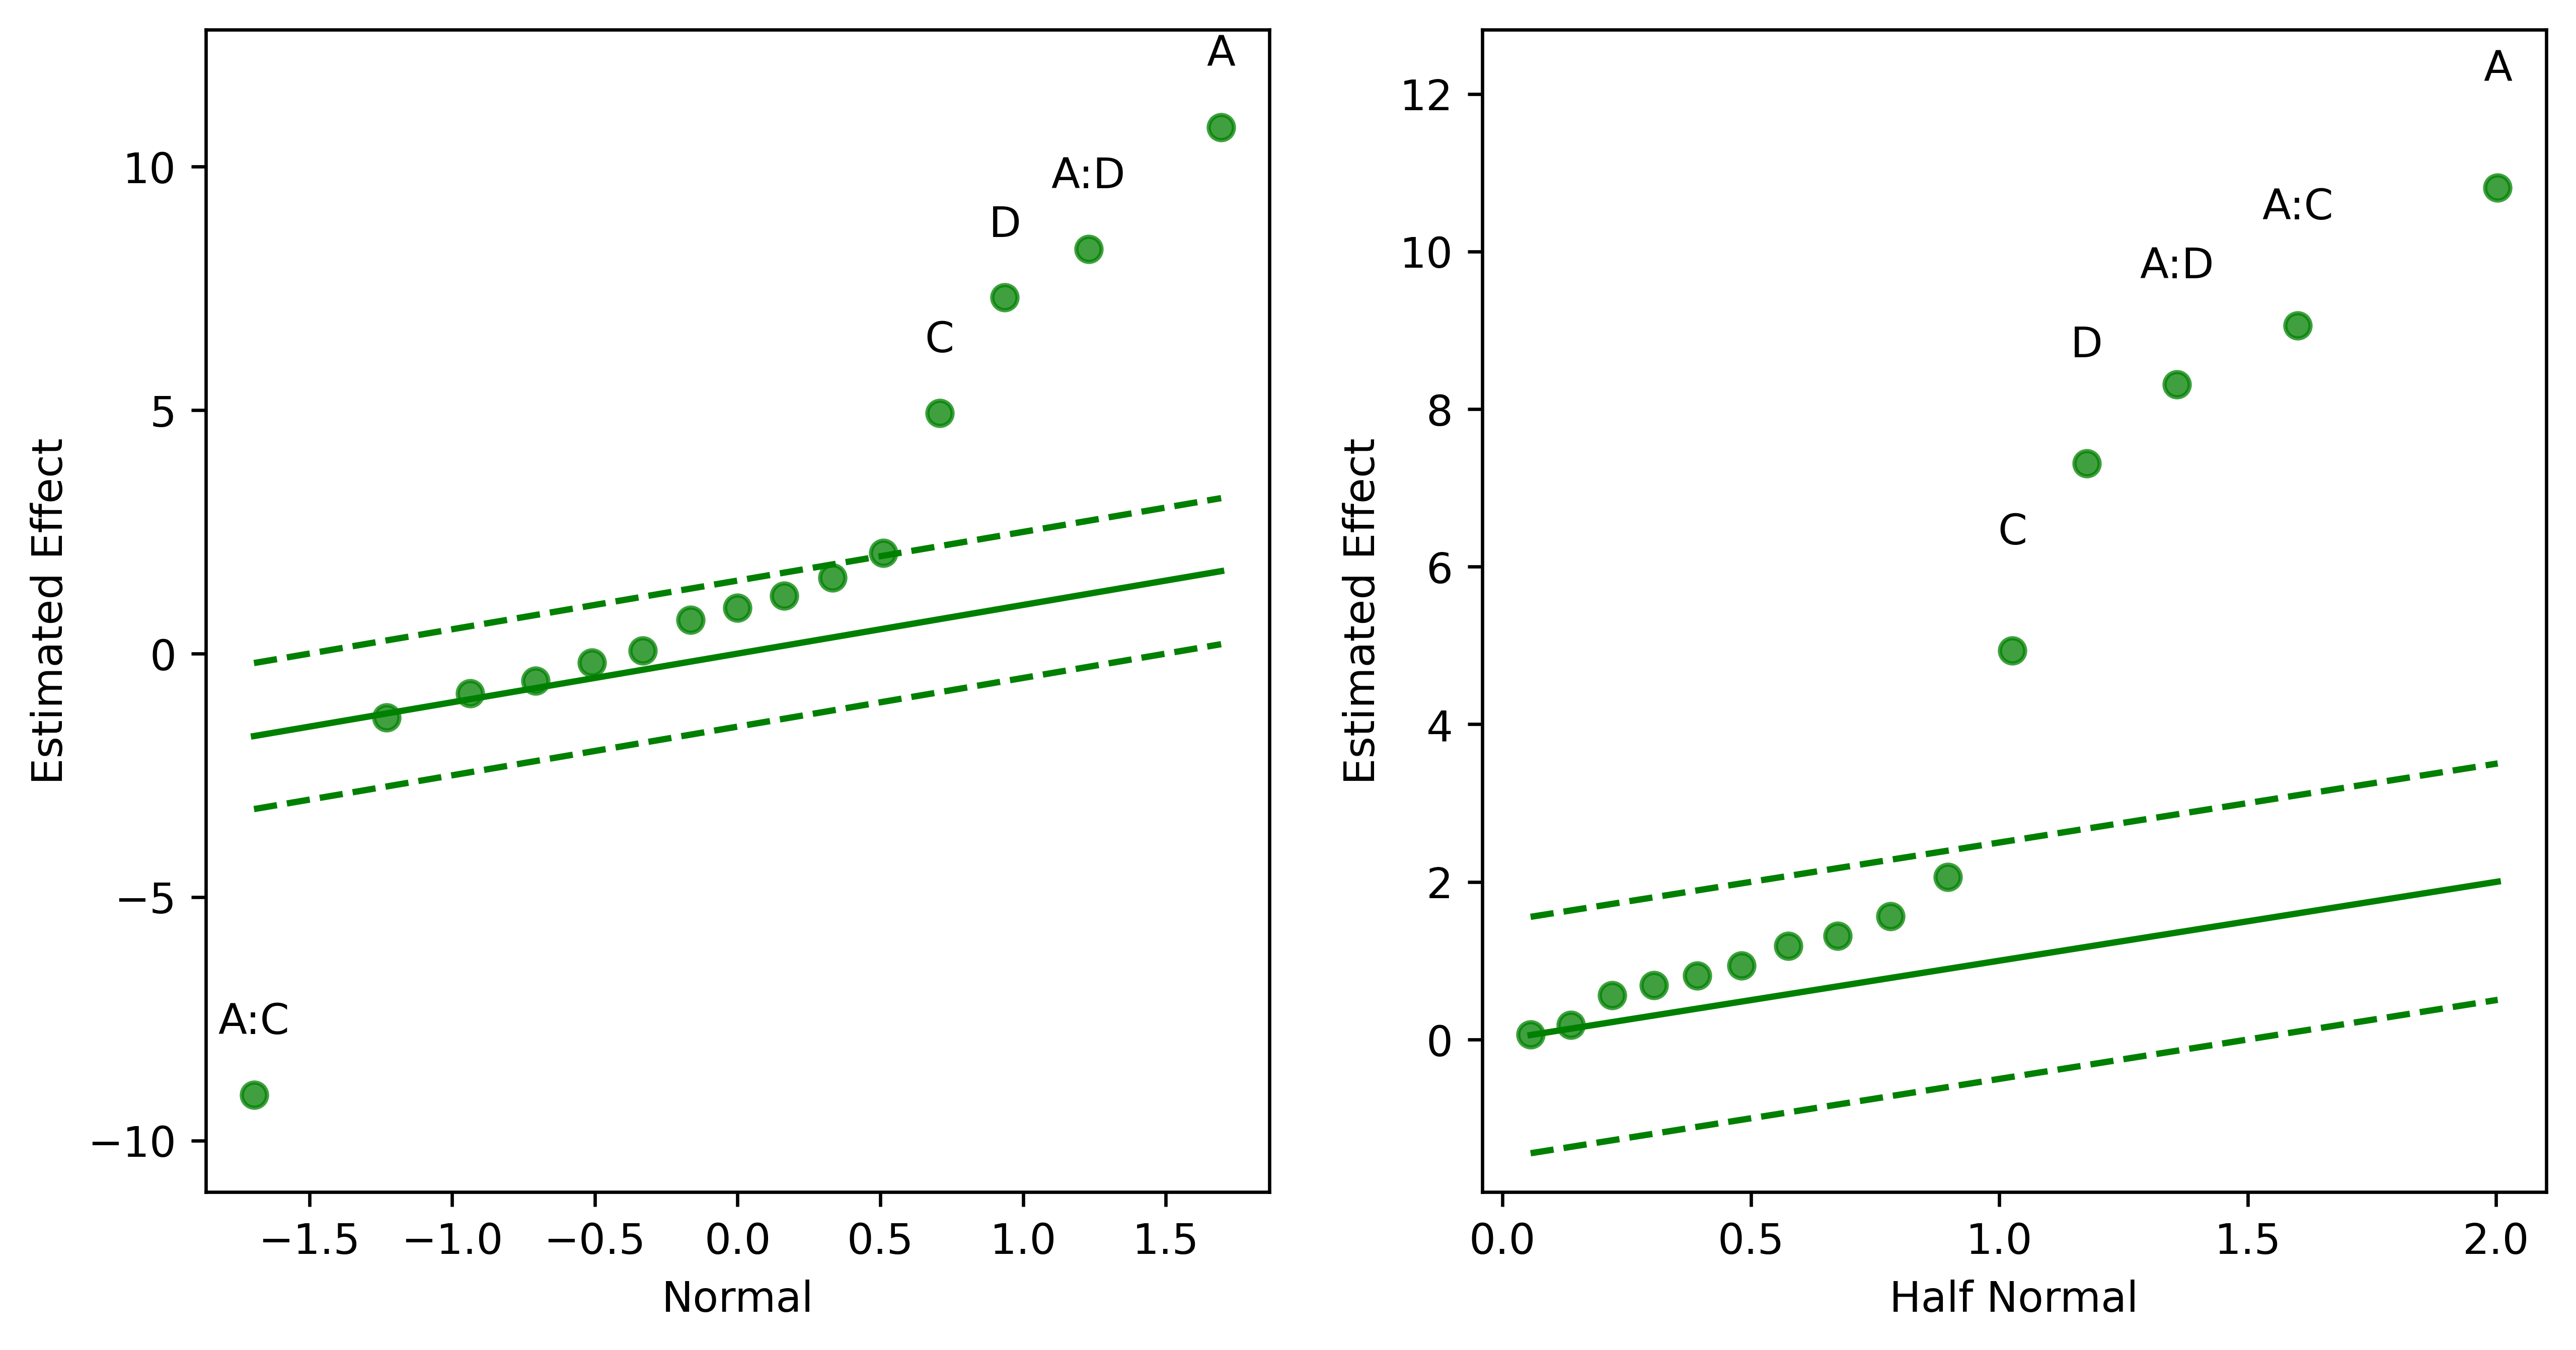

In [407]:
fig, ax = plt.subplots(1,2 , figsize = (10,5), dpi = 600)
parametros = modelo2.params[1:]
parametros = parametros.sort_values()
(osm, osr), _ = st.probplot(parametros, dist = 'norm')

ax[0].scatter(osm, osr, color = 'green', alpha = 0.75)
ax[0].plot(osm, osm, color = 'green')
ax[0].plot(osm, osm + 1.5, color = 'green', linestyle = '--')
ax[0].plot(osm, osm - 1.5, color = 'green', linestyle = '--')

for label, osm_i, osr_i in zip(parametros.index, osm, osr):

    if np.abs(osm_i - osr_i) > 1.6:
        
       ax[0].text(
            x=osm_i,
            y=osr_i+1.5,
            s=label,
            color='black',
            ha='center',
            va='center'
        )

ax[0].set_ylabel('Estimated Effect')
ax[0].set_xlabel('Normal')

ax[0].set_ylim(np.min(osr)-2, np.max(osr)+2)

parametros = parametros.abs().sort_values()





## --- half norm
(osm, osr), _ = st.probplot(parametros, dist = 'halfnorm')

ax[1].scatter(osm, osr, color = 'green', alpha = 0.75)
ax[1].plot(osm, osm, color = 'green')
ax[1].plot(osm, osm + 1.5, color = 'green', linestyle = '--')
ax[1].plot(osm, osm - 1.5, color = 'green', linestyle = '--')

for label, osm_i, osr_i in zip(parametros.index, osm, osr):

    if np.abs(osm_i - osr_i) > 1.5:
        
       ax[1].text(
            x=osm_i,
            y=osr_i+1.5,
            s=label,
            color='black',
            ha='center',
            va='center'
        )
       
ax[1].set_ylim(np.min(osr)-2, np.max(osr)+2)
ax[1].set_ylabel('Estimated Effect')
ax[1].set_xlabel('Half Normal')

Existen también los gráficos de Pareto:

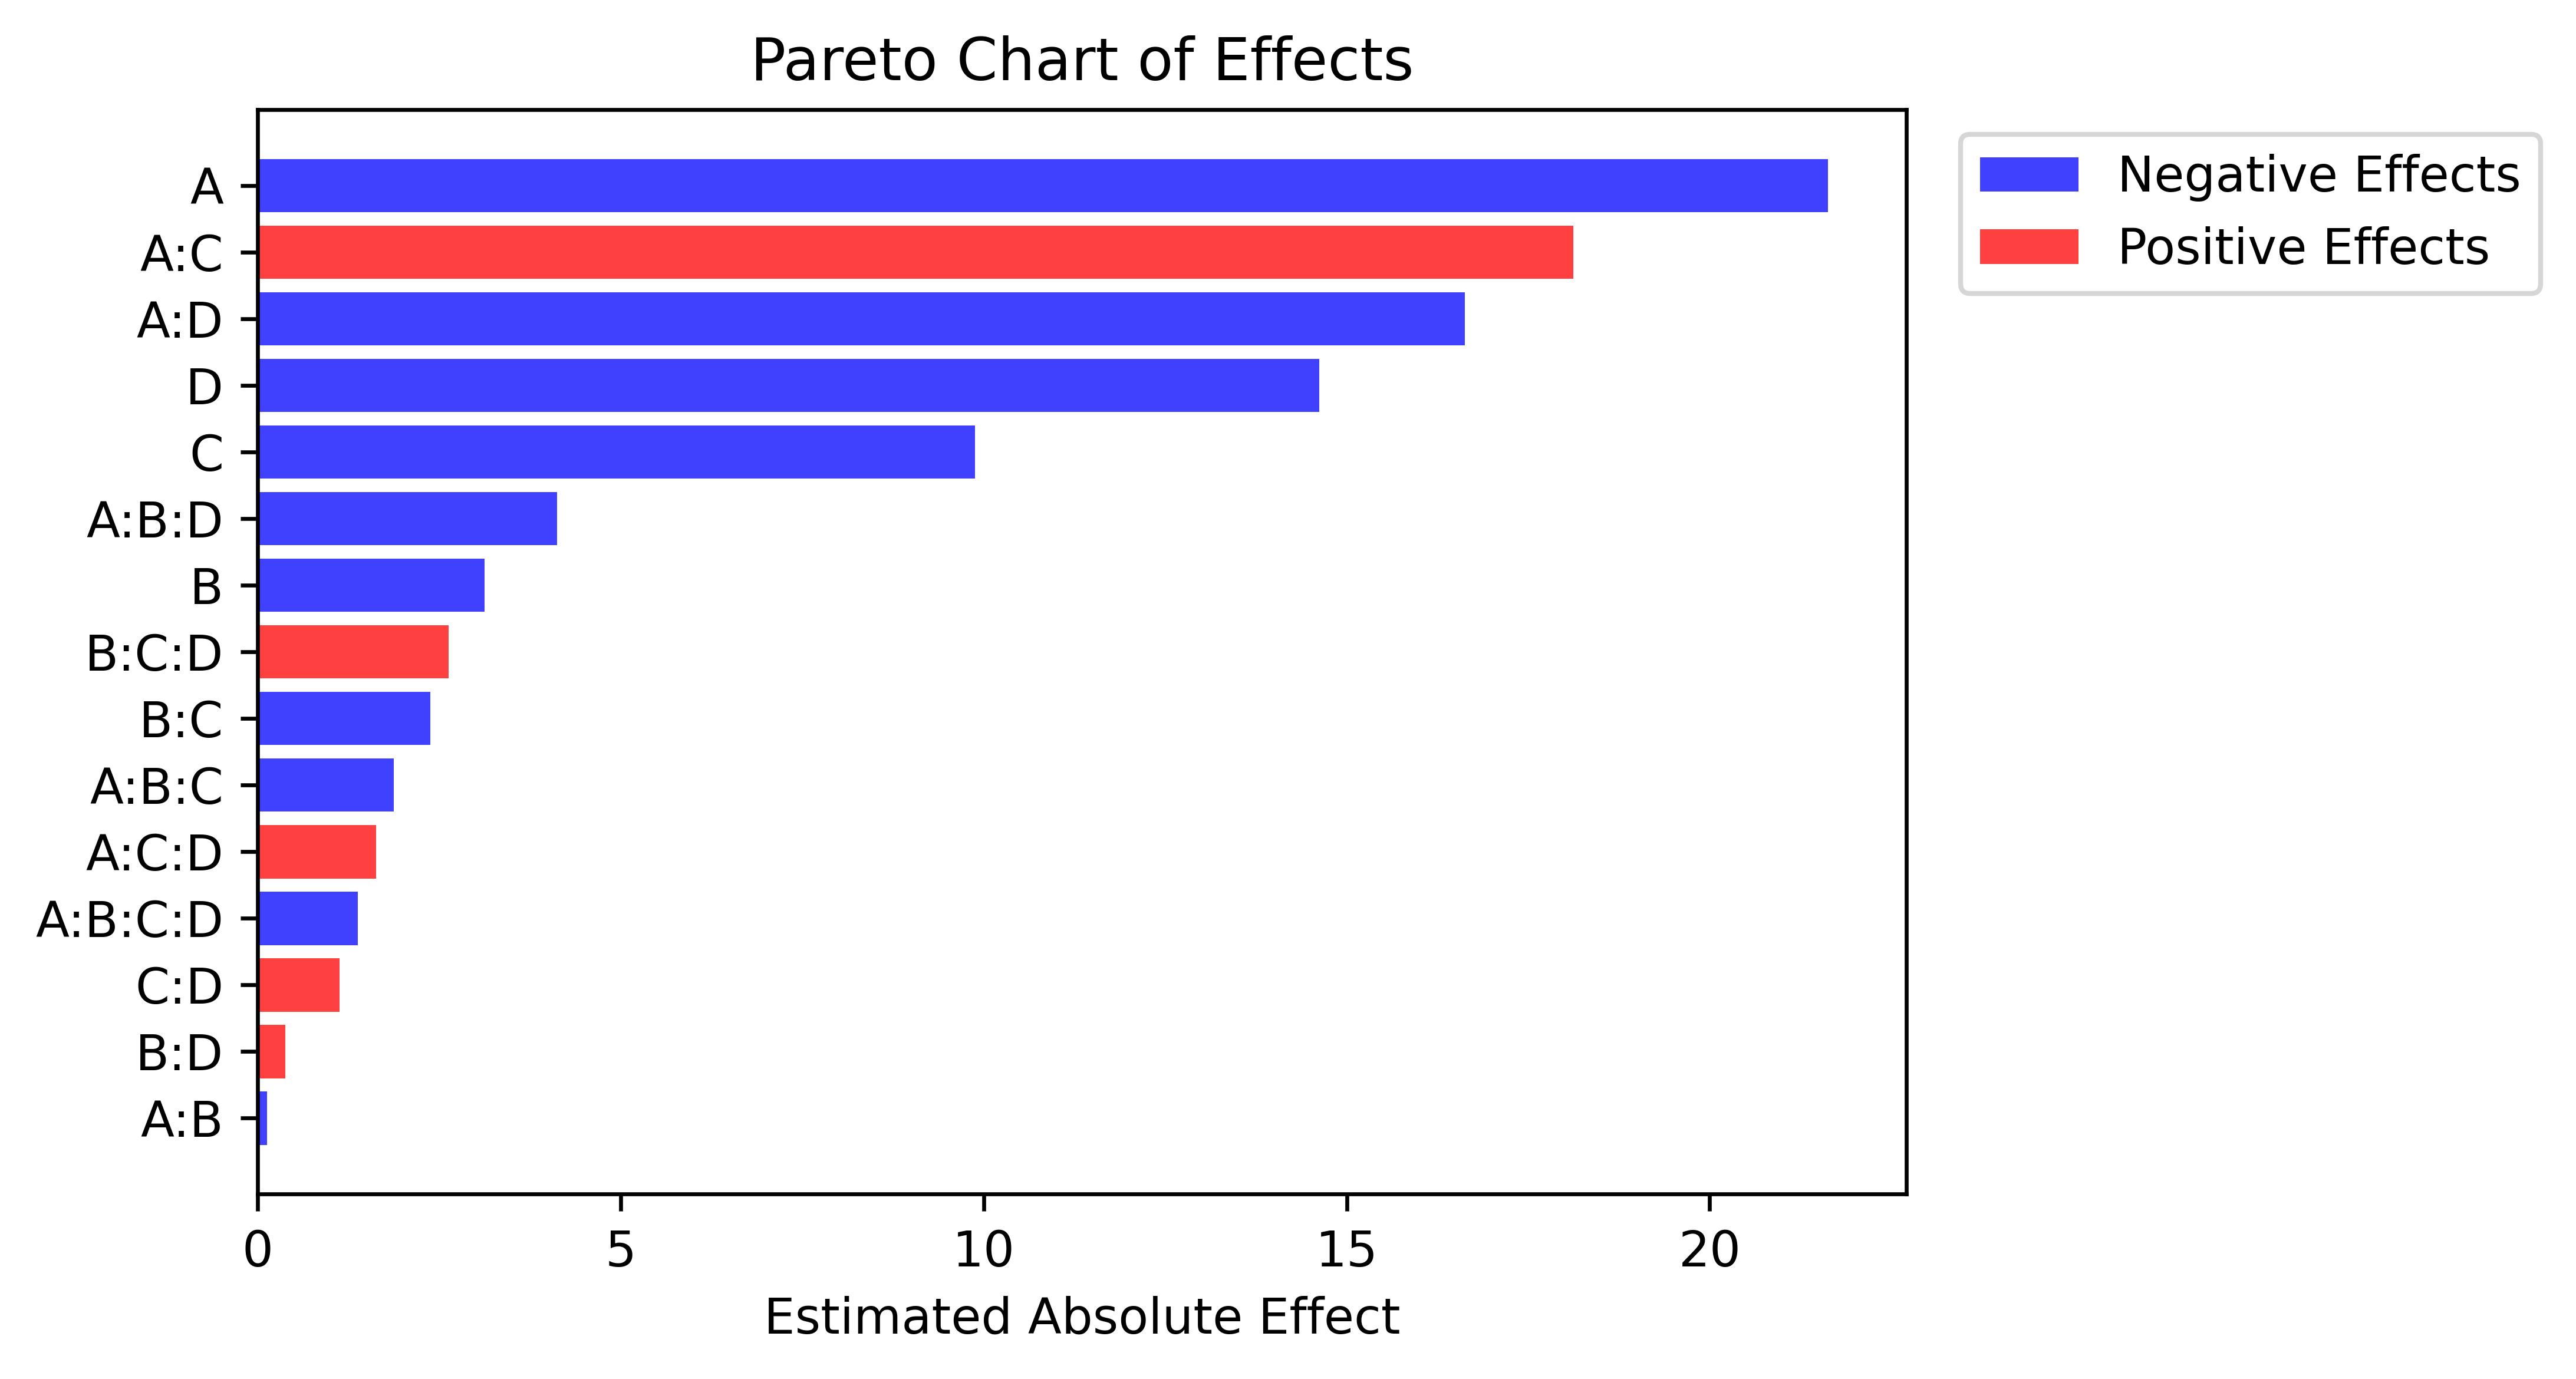

In [428]:
params_pareto = modelo2.params[1:].sort_values(ascending=True, key = lambda x: np.abs(x))
fig, ax = plt.subplots(figsize=(8, 4), dpi=600)
for i, (parametro, valor) in enumerate(params_pareto.items()):
    if valor < 0:
        ax.barh(parametro, np.abs(valor) * 2, color='red', alpha=0.75)
    else:
        ax.barh(parametro, np.abs(valor) * 2, color='blue', alpha=0.75)
        
ax.set_xlabel('Estimated Absolute Effect')
ax.set_title('Pareto Chart of Effects')
ax.legend(['Negative Effects', 'Positive Effects'], loc='upper right',
           bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.show()

## Reducción de Modelos en diseño $2^k$ sin repeticiones

> ¿Es posible eliminar variables del modelo? Si es así, ¿cómo lo haría? ¿Qué ventajas ofrece trabajar con un modelo reducido?

Es posible, en específico la variable B, quedando un modelo compuesto solo por ACD. Esto nos permite tener *replicas* en el sistema. Aumentando la efectividad de los tests estadísticos. 

In [429]:
print(anova_lm(modelo2))

           df        sum_sq    mean_sq    F  PR(>F)
A         1.0  1.870562e+03  1870.5625  0.0     NaN
B         1.0  3.906250e+01    39.0625  0.0     NaN
A:B       1.0  6.250000e-02     0.0625  0.0     NaN
C         1.0  3.900625e+02   390.0625  0.0     NaN
A:C       1.0  1.314062e+03  1314.0625  0.0     NaN
B:C       1.0  2.256250e+01    22.5625  0.0     NaN
A:B:C     1.0  1.406250e+01    14.0625  0.0     NaN
D         1.0  8.555625e+02   855.5625  0.0     NaN
A:D       1.0  1.105563e+03  1105.5625  0.0     NaN
B:D       1.0  5.625000e-01     0.5625  0.0     NaN
A:B:D     1.0  6.806250e+01    68.0625  0.0     NaN
C:D       1.0  5.062500e+00     5.0625  0.0     NaN
A:C:D     1.0  1.056250e+01    10.5625  0.0     NaN
B:C:D     1.0  2.756250e+01    27.5625  0.0     NaN
A:B:C:D   1.0  7.562500e+00     7.5625  0.0     NaN
Residual  0.0  1.565100e-26        inf  NaN     NaN


/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/statsmodels/stats/anova.py:142: RuntimeWarning:

divide by zero encountered in scalar divide



In [430]:
modelo2_red = ols('response ~ A*C*D', data = df_2).fit()
print(modelo2_red.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     35.35
Date:                Wed, 28 May 2025   Prob (F-statistic):           2.12e-05
Time:                        11:36:58   Log-Likelihood:                -42.044
No. Observations:                  16   AIC:                             100.1
Df Residuals:                       8   BIC:                             106.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.0625      1.184     59.164      0.0

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=16



In [431]:
print(anova_lm(modelo2_red))

           df     sum_sq    mean_sq          F    PR(>F)
A         1.0  1870.5625  1870.5625  83.367688  0.000017
C         1.0   390.0625   390.0625  17.384401  0.003124
A:C       1.0  1314.0625  1314.0625  58.565460  0.000060
D         1.0   855.5625   855.5625  38.130919  0.000267
A:D       1.0  1105.5625  1105.5625  49.272981  0.000110
C:D       1.0     5.0625     5.0625   0.225627  0.647483
A:C:D     1.0    10.5625    10.5625   0.470752  0.512032
Residual  8.0   179.5000    22.4375        NaN       NaN


Luego, con la significancia estadística, se puede reducir aún más el modelo.

In [432]:
modelo2_red_red = ols('response ~ A + C + D + A:C + A:D', data = df_2).fit()
print(modelo2_red_red.summary())

                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     56.74
Date:                Wed, 28 May 2025   Prob (F-statistic):           5.14e-07
Time:                        11:37:14   Log-Likelihood:                -42.711
No. Observations:                  16   AIC:                             97.42
Df Residuals:                      10   BIC:                             102.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.0625      1.104     63.444      0.0

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=16



In [433]:
print(anova_lm(modelo2_red_red))

            df     sum_sq    mean_sq          F    PR(>F)
A          1.0  1870.5625  1870.5625  95.864830  0.000002
C          1.0   390.0625   390.0625  19.990391  0.001195
D          1.0   855.5625   855.5625  43.846893  0.000059
A:C        1.0  1314.0625  1314.0625  67.344651  0.000009
A:D        1.0  1105.5625  1105.5625  56.659193  0.000020
Residual  10.0   195.1250    19.5125        NaN       NaN


# Diseño Factorial $2^k$ sin repeticiones y con puntos centrales

Agregamos los siguientes puntos a nuestro df previo

In [435]:
df_central = pd.DataFrame({
    'A': [0,0,0,0],
    'B': [0,0,0,0],
    'C': [0,0,0,0],
    'D': [0,0,0,0],
    'response': [73,75,66,69]
})

df_2_central = pd.concat([df_2, df_central])

Una primera ventaja de este tipo de diseños, es que nos permite estimar errores puros del modelo debido a que poseemos repeticiones en los datos.

In [436]:
modelo_central = ols('response ~ A*B*C*D', data = df_2_central).fit()
print(modelo_central.summary())

                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     30.41
Date:                Wed, 28 May 2025   Prob (F-statistic):            0.00232
Time:                        11:49:22   Log-Likelihood:                -37.594
No. Observations:                  20   AIC:                             107.2
Df Residuals:                       4   BIC:                             123.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.2000      0.793     88.565      0.0

## Estimación de efectos de segundo orden

Adicionar puntos centrales nos permite estimar la presencia de efectos de segundo orden.

Existen diferentes formas de realizar la estimación de la significancia de la presencia de estos efectos, pero un test ANOVA que los considere es la manera más sencilla -al menos en python.

> Realice un análisis ANOVA para determinar si existe evidencia estadística de curvatura en la superficie de respuesta.
Para realizar este procedimiento, debemos incluir el componente de curvatura (la suma de los coeficientes cuadráticos) en la formula de la ecuación de ANOVA.

In [437]:
anova_curv = ols('response ~ A*B*C*D + I(np.power(A, 2) + np.power(B,2) + np.power(C, 2) + np.power(D, 2))',
                 data = df_2_central).fit()
print(anova_lm(anova_curv))

                                                     df     sum_sq    mean_sq  \
A                                                   1.0  1870.5625  1870.5625   
B                                                   1.0    39.0625    39.0625   
A:B                                                 1.0     0.0625     0.0625   
C                                                   1.0   390.0625   390.0625   
A:C                                                 1.0  1314.0625  1314.0625   
B:C                                                 1.0    22.5625    22.5625   
A:B:C                                               1.0    14.0625    14.0625   
D                                                   1.0   855.5625   855.5625   
A:D                                                 1.0  1105.5625  1105.5625   
B:D                                                 1.0     0.5625     0.5625   
A:B:D                                               1.0    68.0625    68.0625   
C:D                         

Entonces, como posee un valor-p de 0.78 podemos concluir que en este diseño, no existen relaciones de alto orden entre las variables explicativas y de respuesta.

> Discuta si el diseño utilizado es adecuado para explorar interacciones y curvatura. ¿Qué tipo de diseño sugeriría si se espera no linealidad?